Estoy tratando de recuperar la info cruda del final del experimento que hice para medir la dependencia con el umbral. 

De los registros de consentimiento que tengo anotados figura que los datos los tome entre el 29/3/16 y el 14/4/16

La idea es ir a backups de los db.json y volver a procesar todo rapido con la experiencia que ya tengo acumulada para hacer graficos diferentes a los que tengo guardados que son horribles. 

No tengo muy fresco como era el setup experimental ni la estructura de datos guardados, pero voy a ver que puedo hacer al respecto. Deberia tener al menos registro de 14 usuarios. 

Copio a la carpeta data todos los archivos json que corresponden a esas fechas. Quiero un codigo que busque todos los archivos y recupere la info util

Acabo de encontrar en este archivo que los sujetos completaron una encuesta cuando terminaron y tiene marcas temporales!! :)

https://docs.google.com/spreadsheets/d/1hV9QL78TFX2Ka4ROaAg9mHZ2WgcUDArZM2W8W_15wkg/edit#gid=1050318047



In [1]:
# Primero queremos listas todos los archivos

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./data/') if isfile(join('./data/', f))]

In [2]:
# Queremos transformar cada archivo en un dataframe con etradas para ver entradas repetidas

import pandas as pd
import json

#Creamos la lista vacia de envios

sesiones = []
levels = []
convergencias = []

#Buscamos leer todas las entradas
for file in onlyfiles:
    with open('./data/'+file) as data_file:
            db = json.load(data_file)
    for envio in db['Envio']:
        if envio['tipoDeEnvio'] == 'NEWSESION':
            sesiones = sesiones + [envio]
        elif envio['tipoDeEnvio'] == 'NEWLEVEL':
            levels = levels + [envio]
        elif envio['tipoDeEnvio'] == 'CONVERGENCIA':
            convergencias = convergencias + [envio]
        elif envio['tipoDeEnvio']:
            print (envio['tipoDeEnvio'])
        else: 
            print (envio)

# Filtramos por envios unicos
envioshechos = []

sesionesUnique = []
for envio in sesiones:
    if not envio['instance'] in envioshechos:
        sesionesUnique = sesionesUnique + [json.loads(envio['contenido'])]
        envioshechos = envioshechos + [envio['instance']]

levelsUnique = []
for envio in levels:
    if not envio['instance'] in envioshechos:
        levelsUnique = levelsUnique + [json.loads(envio['contenido'])]
        envioshechos = envioshechos + [envio['instance']]

convergenciasUnique = []
for envio in convergencias:
    if not envio['instance'] in envioshechos:
        convergenciasUnique = convergenciasUnique + [json.loads(envio['contenido'])]
        envioshechos = envioshechos + [envio['instance']]


In [3]:
# Acabo de descubrir que los enviode Pierina nunca se hicieron bien. Copie en la carpeta dataCruda los envios que nunca se hicieron y recupere de la compu
onlyfiles2 = [f for f in listdir('./DataCruda/') if isfile(join('./DataCruda/', f))]
import os

for file in onlyfiles2:
    name, ext = os.path.splitext( os.path.basename(file))
    with open('./DataCruda/'+file) as data_file:
            data = json.load(data_file)
    if not int(name) in envioshechos:
        if ext == '.NEWLEVEL':
            levelsUnique = levelsUnique + [data]
        if ext == '.NEWSESION':
            sesionesUnique = sesionesUnique + [data]
        if ext == '.CONVERGENCIA':
            convergenciasUnique = convergenciasUnique + [data]    

        

Definimos la lista de usuarios que hicieron el experimento. Recupere de la compu donde se hicieron quien es quien a partir de las carpetas donde se guardaron los datos

In [4]:
usuariosOLD = {1459443370368:'Agustin', 1460500029182:'Chalukian', 1460568434768:'Chechu',1459459628908:'Euge',
           1459455977180:'Flor', 1459450579229:'Guido', 1460384100961:'Jule', 1459368818910:'Lungo',
           1460499050987:'Marta', 1459358889070:'Martina', 1460645753225:'Pierina', 1459350343607:'Roli'}
usuarios = {1459443370368:'Agustin', 1460500029182:'Chalukian', 1460568434768:'Chechu',1459459628908:'Euge',
           1459455977180:'Flor', 1459450579229:'Guido', 1460384100961:'Jule', 1459368818910:'Lungo',
           1460497107413:'Marta', 1459358889070:'Martina', 1460645753225:'Pierina', 1459350343607:'Roli'}

In [5]:
# Queremos aplicar un filtro donde, primero se filtren todoas las entradas que tengan una sesion para usuarios validos
sesionesFiltradas = [item for item in sesionesUnique if item['userId'] in usuarios.keys()]
# Por alguna razon se ve que un usuario hizo dos sesiones. 

# Aplicamos un filtro que selecciones los niveles y las convergencias que hayan sucedido en alguna de las sesiones filtradas
sesionesInstances = [item['sessionInstance'] for item in sesionesFiltradas]

levelsFiltrados = [item for item in levelsUnique if item['session']['sessionInstance'] in sesionesInstances]
convergenciasFiltradas = [item for item in convergenciasUnique if item['expLog']['session']['sessionInstance'] in sesionesInstances]

In [6]:
# Pasamos el formato a dataframe
sesionesPanda = pd.DataFrame(sesionesFiltradas)
levelsPanda = pd.DataFrame(levelsFiltrados)
convergenciasPanda = pd.DataFrame(convergenciasFiltradas)

In [10]:
### Retocamos un poco la info para que sea mas manejable (basicamente hay que extraer cada cosa de adentro de los dict
cpd = convergenciasPanda

for key in cpd.iloc[0]['expLog']:
    cpd[key] = cpd['expLog'].map(lambda x: x[key])
cpd = cpd.drop('expLog',1)
for key in cpd.iloc[0]['session']:
    cpd[key] = cpd['session'].map(lambda x: x[key])
cpd = cpd.drop('session',1)

for key in cpd.iloc[0]['dinamica']:
    cpd[key] = cpd['dinamica'].map(lambda x: x[key])
cpd = cpd.drop('dinamica',1)
cpd['ultimoTrial'] = cpd['historial'].map(lambda x: x[-1] if (len (x) > 1) else None)
for key in cpd.iloc[0]['ultimoTrial']:
    cpd[key] = cpd['ultimoTrial'].map(lambda x: x[key] if (x) else None)
cpd = cpd.drop('ultimoTrial',1)

for key in cpd.iloc[0]['estimulo']: # Hay que tener cuidado que no todos los dict son iguales. Este es un dict de paralelismio
    cpd[key] = cpd['estimulo'].map(lambda x: None if not x else x[key] if key in x else None)
for key in cpd.iloc[7]['estimulo']: # Hay que tener cuidado que no todos los dict son iguales. Este es un dict de angulos
    cpd[key] = cpd['estimulo'].map(lambda x: None if not x else x[key] if key in x else None)
cpd = cpd.drop('estimulo',1)

#Revisando los archivos fuente dentro del jar de la versión 31 (que es la que se uso en el experimento) chequie que el valor reportado de los estimulos es el semi angulo para el caso de las serie de paralelismo.
#En el caso de los angulos, es el angulo formado, que ya procesa el tema dela desviacion.
cpd['desviacionDoble'] = cpd['desviacion'] * 2

# Sacamos niveles espureos
cpd = cpd[cpd['expName']!='UmbralAngulosTutorial']
cpd = cpd[cpd['expName']!='UmbralParalelismoTutorial']

# Sacamos los registros de niveles que se marcaron en tiempo de ejecusion como no temrinados
cpd = cpd[cpd['convergenciaFinalizada']]

Ahora vamos a hacer los graficos al estilo pandas como hicimos las distribuciones en el experimento de los resultados finales.

In [8]:
orientaciones = cpd['referencia'].unique()
experimentos = cpd['expName'].unique()
print (sesionesPanda['userId'].unique())

[1459350343607 1459358889070 1459368818910 1459443370368 1459450579229
 1459455977180 1459459628908 1460384100961 1460497107413 1460500029182
 1460568434768 1460645753225]


4      -1.451540
5       0.200000
6       0.620748
7     -12.137063
8      -0.265461
9       0.200000
10    180.000000
11    180.000000
12    240.000000
13    180.000000
14    376.000000
15    340.000000
20     12.137063
21     -0.200000
22    -28.380983
...
195    348.000000
196    364.000000
197    240.000000
202     50.000000
203    -50.000000
204    -16.109604
205      0.538802
206      0.200000
207     -0.200000
208    178.000000
209    180.000000
210    352.000000
212    220.000000
213    280.000000
214    520.000000
Name: desviacionDoble, Length: 144, dtype: float64
4      -1.451540
5       0.200000
6       0.620748
7     -12.137063
8      -0.265461
9       0.200000
10    180.000000
11    180.000000
12    240.000000
13    180.000000
14    376.000000
15    340.000000
20     12.137063
21     -0.200000
22    -28.380983
...
195    348.000000
196    364.000000
197    240.000000
202     50.000000
203    -50.000000
204    -16.109604
205      0.538802
206      0.200000
207     -0.200000

ValueError: cannot convert float NaN to integer

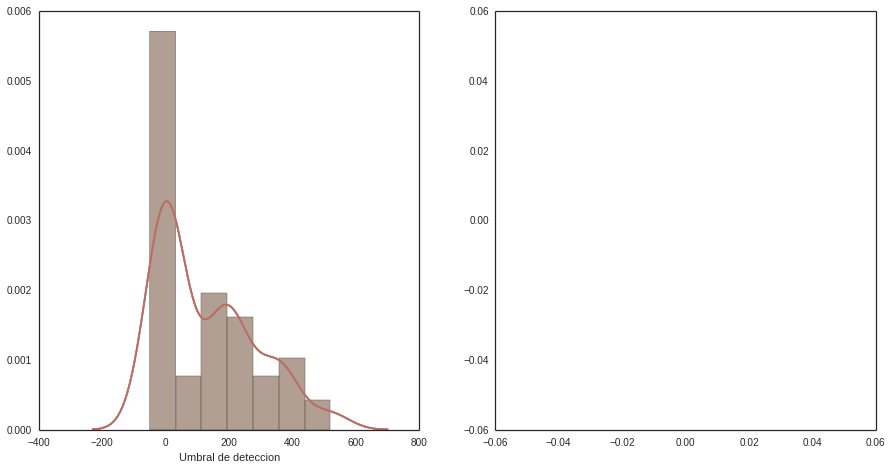

In [29]:
for experimento in experimentos:
    for orientacion in orientaciones[:3]:
        print (len(cpd[(cpd['referencia']==orientacion) & (cpd['expName']==experimento)]))
        if experimento == 'UmbralParalelismoPiloto':
            data=cpd['desviacionDoble']
        if experimento == 'UmbralAngulosPiloto':
            data=cpd['anguloFormado']
#cpd.columns


In [22]:
cpd.columns

Index(['expName', 'levelInstance', 'resourcesVersion', 'codeVersion', 'plataforma', 'userId', 'sessionInstance', 'ultimoMEAN', 'historial', 'convergenciaAlcanzada', 'tamanoVentanaAnalisisConvergencia', 'proporcionAciertos', 'referencia', 'sdEsperada', 'listaEstimulos', 'convergenciaFinalizada', 'nivelEstimulo', 'saltosActivos', 'identificador', 'ultimaSD', 'acertado', 'idResource', 'nivelSenal', 'desviacion', 'idTrial', 'anguloFormado', 'class', 'desviacionDoble'], dtype='object')

In [25]:
%matplotlib inline


/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


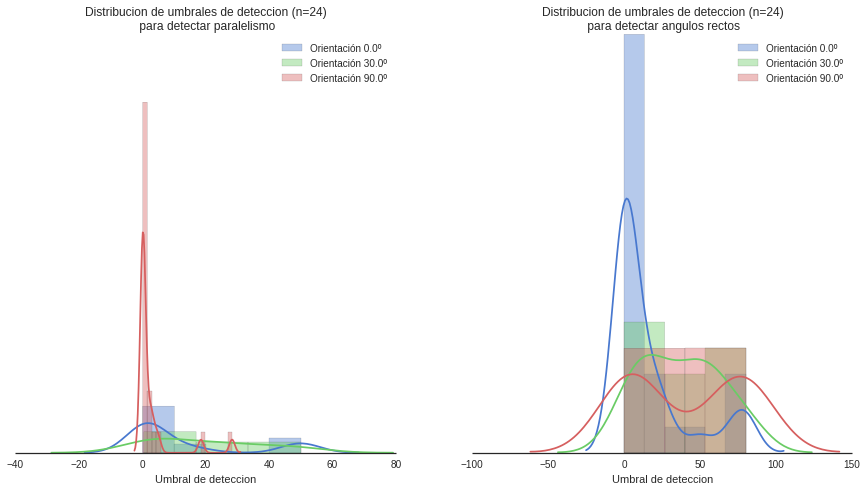

In [44]:

import seaborn as sns
import matplotlib.pyplot as plt


sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.despine(left=True)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7.5)

for experimento in experimentos:
    for orientacion in orientaciones[:3]:
        
        if experimento == 'UmbralParalelismoPiloto':
            data=cpd[(cpd['referencia']==orientacion) & (cpd['expName']==experimento)]['desviacionDoble']
            data = [valor if valor>0 else -valor for valor in data]
            sns.distplot(data, label='Orientación ' + str(orientacion)+'º', axlabel='Umbral de deteccion', ax=ax[0])
            
        if experimento == 'UmbralAngulosPiloto':
            data=cpd[(cpd['referencia']==orientacion) & (cpd['expName']==experimento)]['anguloFormado']
            data = [valor -90 if valor>=90 else 90 - valor for valor in data]
            sns.distplot(data, label='Orientación ' + str(orientacion)+'º', axlabel='Umbral de deteccion', ax=ax[1])
            
for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].legend()
        
ax[0].set_title('Distribucion de umbrales de deteccion (n=24)\n para detectar paralelismo')
ax[1].set_title('Distribucion de umbrales de deteccion (n=24)\n para detectar angulos rectos')
#cpd.columns
fig.savefig('./ExperimentoUmbralResultadosGlobales', bbox_inches='tight')
fig.show()